### TimeCopilot Forecaster for Cryptocurrency
This notebook will work to exemplify the use of TimeCopilot in the context of missing data, anomaly detection and forecasting usage on a dataframe that involves distinct ids. 

In [ ]:
import sys

# Import all the timecopilot goodies
import timecopilot
from timecopilot import TimeCopilotForecaster
from timecopilot.models.stats import SeasonalNaive, Theta
from timecopilot.models.foundation.chronos import Chronos

from timecopilot.models.prophet import Prophet
from timecopilot.models.stats import AutoARIMA, AutoETS, SeasonalNaive
from timecopilot.models.foundation.moirai import Moirai

# Import basic libraries
import pandas as pd
import kagglehub
import os
import numpy as np

#### Data import 
Data will come from a Kaggle dataset. This will contain several crypto daily symbol prices, up to july 2021. 

In [2]:
# Download the dataset from Kaggle for crypto prices history
path = kagglehub.dataset_download("sudalairajkumar/cryptocurrencypricehistory")

In [3]:
files = os.listdir(path)
files = [path+'/'+x for x in files]

In [4]:
big_df = pd.DataFrame()

# Read all filez and set them up to the readable structure for timecopilot
for file in files:
    temp_df = pd.read_csv(file)
    temp_df = temp_df[['Symbol','Date','Close']]
    temp_df.columns = ['unique_id','ds','y']
    big_df = pd.concat([big_df,temp_df])

big_df = big_df.reset_index(drop=True)
big_df["ds"] = pd.to_datetime(big_df["ds"], dayfirst=True, errors="coerce")

# This line will be kept for execution time sanity, feel free to remove it if you want to stress timing a little further. 
# big_df = big_df[big_df.ds >= "2021-01-01"]
cryptos=['MIOTA','XEM','ETH','LTC','DOGE','CRO','USDC','ADA']
big_df=big_df[big_df.unique_id.isin(cryptos)]
big_df=big_df.reset_index(drop=True)
big_df

,unique_id,ds,y
0,MIOTA,2017-06-14 23:59:59,0.528916
1,MIOTA,2017-06-15 23:59:59,0.363661
2,MIOTA,2017-06-16 23:59:59,0.410757
3,MIOTA,2017-06-17 23:59:59,0.419906
4,MIOTA,2017-06-18 23:59:59,0.405862
...,...,...,...
14989,ADA,2021-07-02 23:59:59,1.394397
14990,ADA,2021-07-03 23:59:59,1.406836
14991,ADA,2021-07-04 23:59:59,1.458184
14992,ADA,2021-07-05 23:59:59,1.404898


Let's take a look at all the unique ids found in the dataframe

In [5]:
print(big_df.unique_id.unique())

['MIOTA' 'XEM' 'ETH' 'LTC' 'DOGE' 'CRO' 'USDC' 'ADA']


Notice there's different unique_ids for the dataset. TimeCopilot will use this to guide the process for plotting and forecasting. 

In [6]:
# Setup TimeCopilotForecaster object and load the models that will operate on it
tcf = TimeCopilotForecaster(
    models=[
        Chronos(repo_id="amazon/chronos-bolt-mini"),
        SeasonalNaive(),
        Theta(),
    ]
)

TimeCopilot is capable of working on several unique ids at a given time. Let's plot all of them 

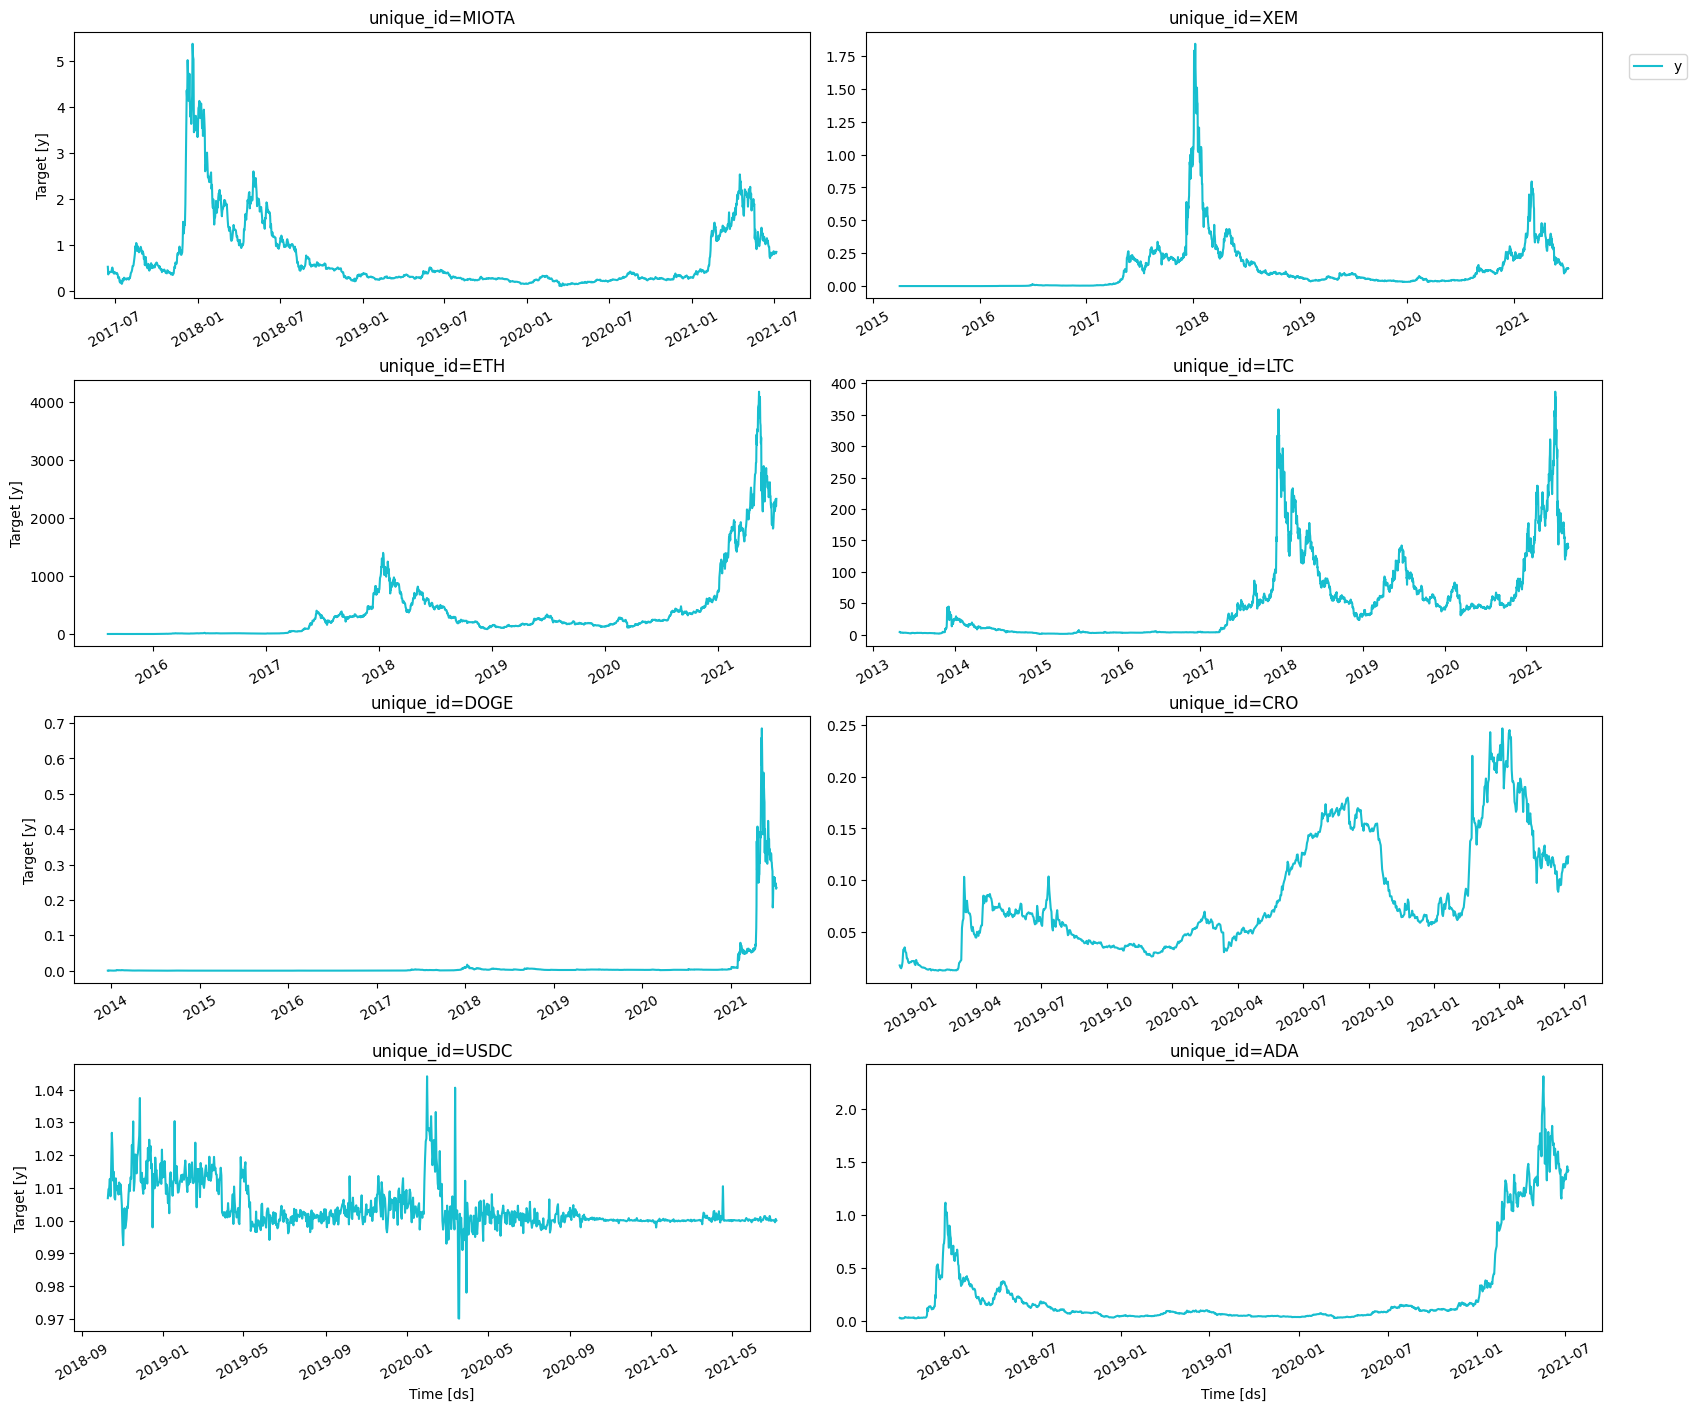

In [7]:
tcf.plot(big_df)

We would also like to add a couple missing values deliberately on the data, in order to stress TimeCopilot's ability to handle misbehaved data. Let's also shuffle it for fun

In [8]:
def add_missing(df, col="y", frac=0.1, seed=0):
    """
    Randomly set a fraction of values in `col` to NaN.
    """
    df_out = df.copy()
    rng = np.random.default_rng(seed)
    n = int(len(df_out) * frac)
    idx = rng.choice(df_out.index, size=n, replace=False)
    df_out.loc[idx, col] = np.nan
    return df_out

df_missing = add_missing(big_df, col="y", frac=0.03, seed=42)
df_missing = df_missing.sample(frac=1, random_state=42).reset_index(drop=True)
print(df_missing)

      unique_id                  ds           y
0          USDC 2020-12-08 23:59:59    1.000102
1           LTC 2014-10-21 23:59:59    3.940010
2          DOGE 2016-10-25 23:59:59    0.000219
3         MIOTA 2019-10-24 23:59:59    0.256239
4           LTC 2013-06-03 23:59:59    2.725560
...         ...                 ...         ...
14989       ETH 2019-06-27 23:59:59  294.267645
14990      USDC 2020-12-17 23:59:59    0.999829
14991       ETH 2020-01-12 23:59:59  145.873931
14992     MIOTA 2019-10-22 23:59:59    0.270907
14993       LTC 2016-12-27 23:59:59    4.469400

[14994 rows x 3 columns]


TimeCopilot can still plot data with the missing values, and will be guided by the time signature provided in the column 'ds', regardless of the shuffling and corruption the data has been put through. 

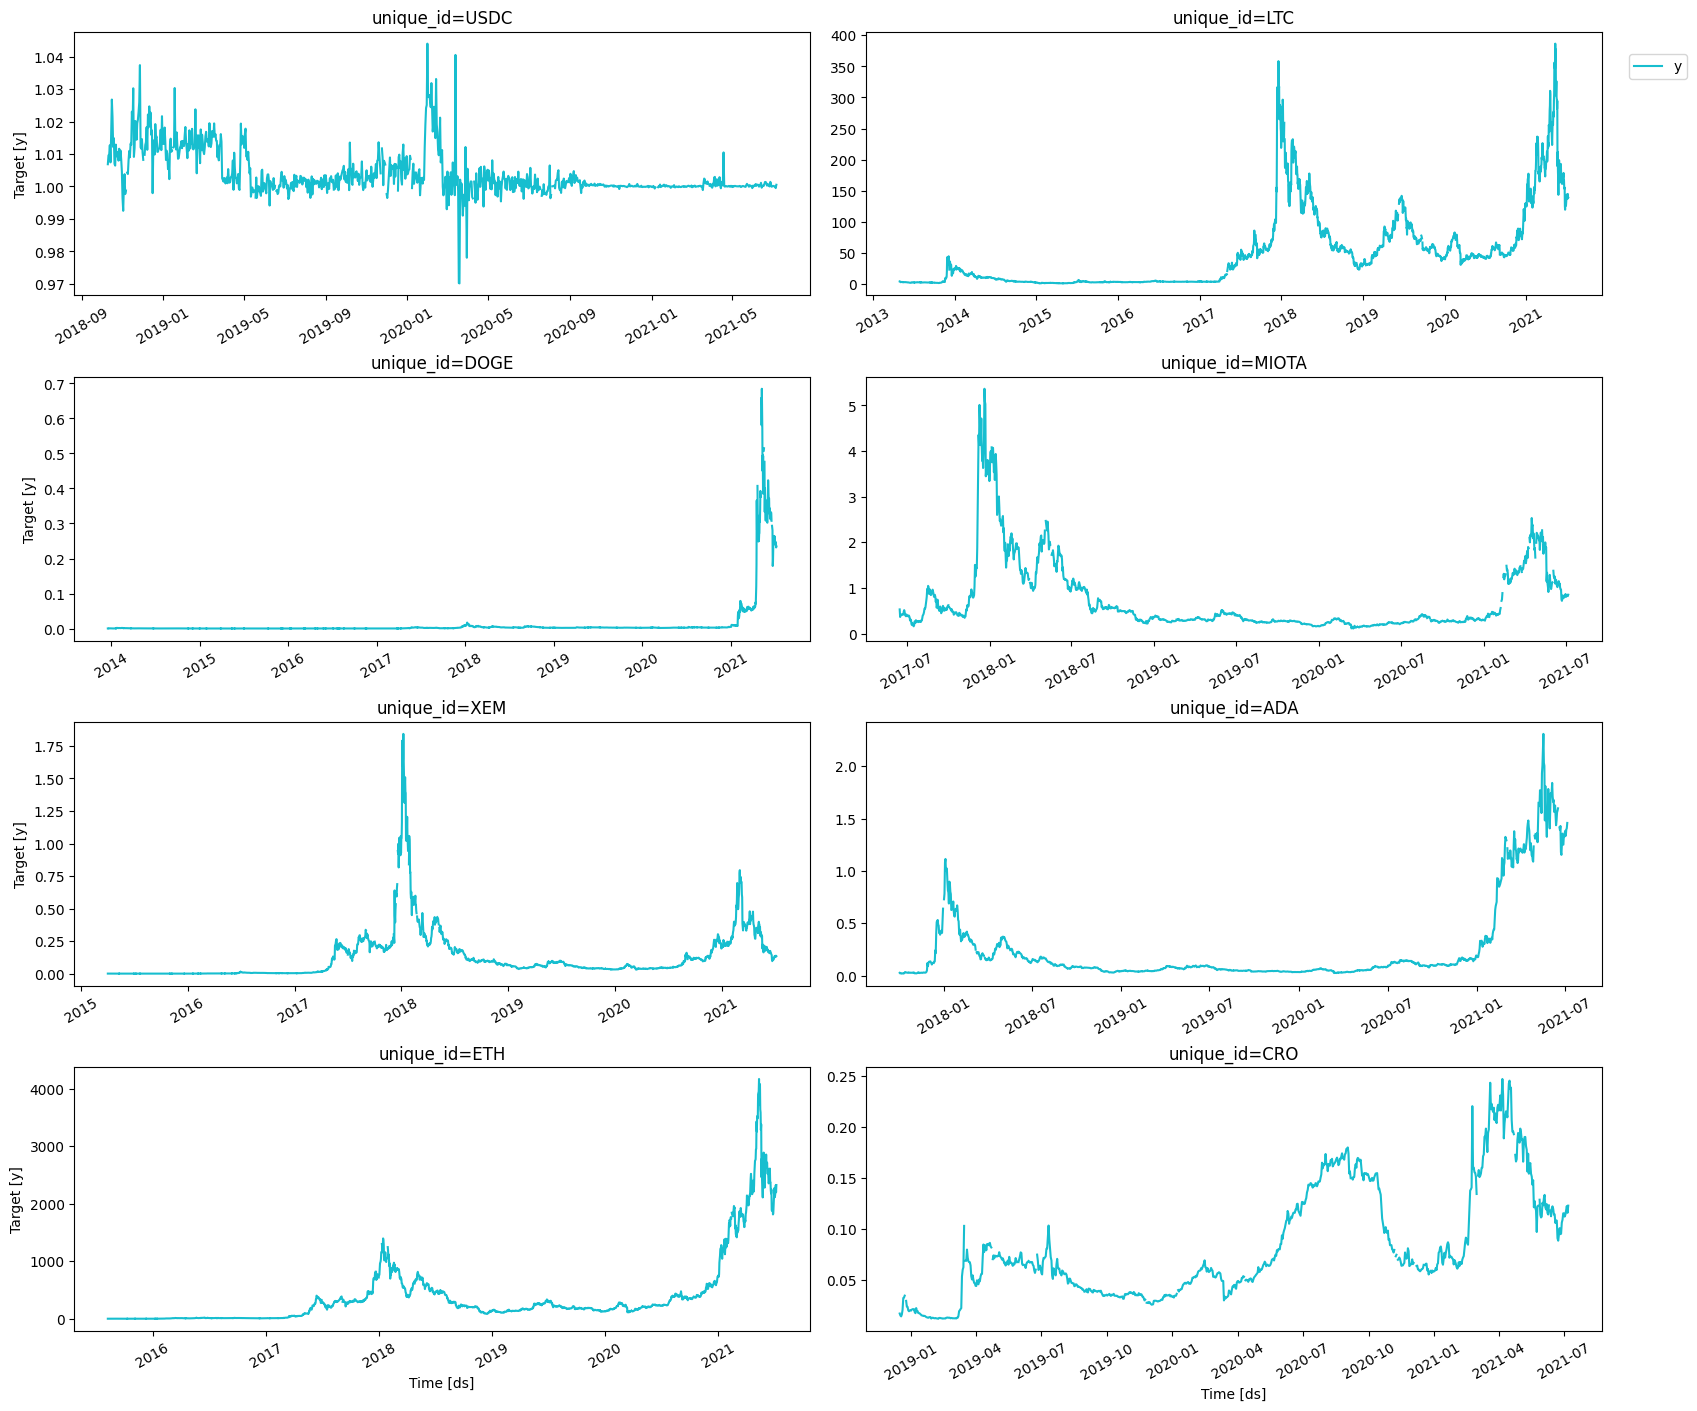

In [9]:
tcf.plot(df_missing)

In the context of crypto pricing, volatility is incredibly common. It'll be important to pinpoint anomalies detection. 

Note that the parameter h and the stationality are both undefined for all data, since crypto doesn't precisely follow any rules regarding the seasonality of its behaviour. 

In [ ]:
anomalies_df = tcf.detect_anomalies(df=big_df, level=95)

In [ ]:
anomalies_df_missing = tcf.detect_anomalies(df=df_missing, level=95)

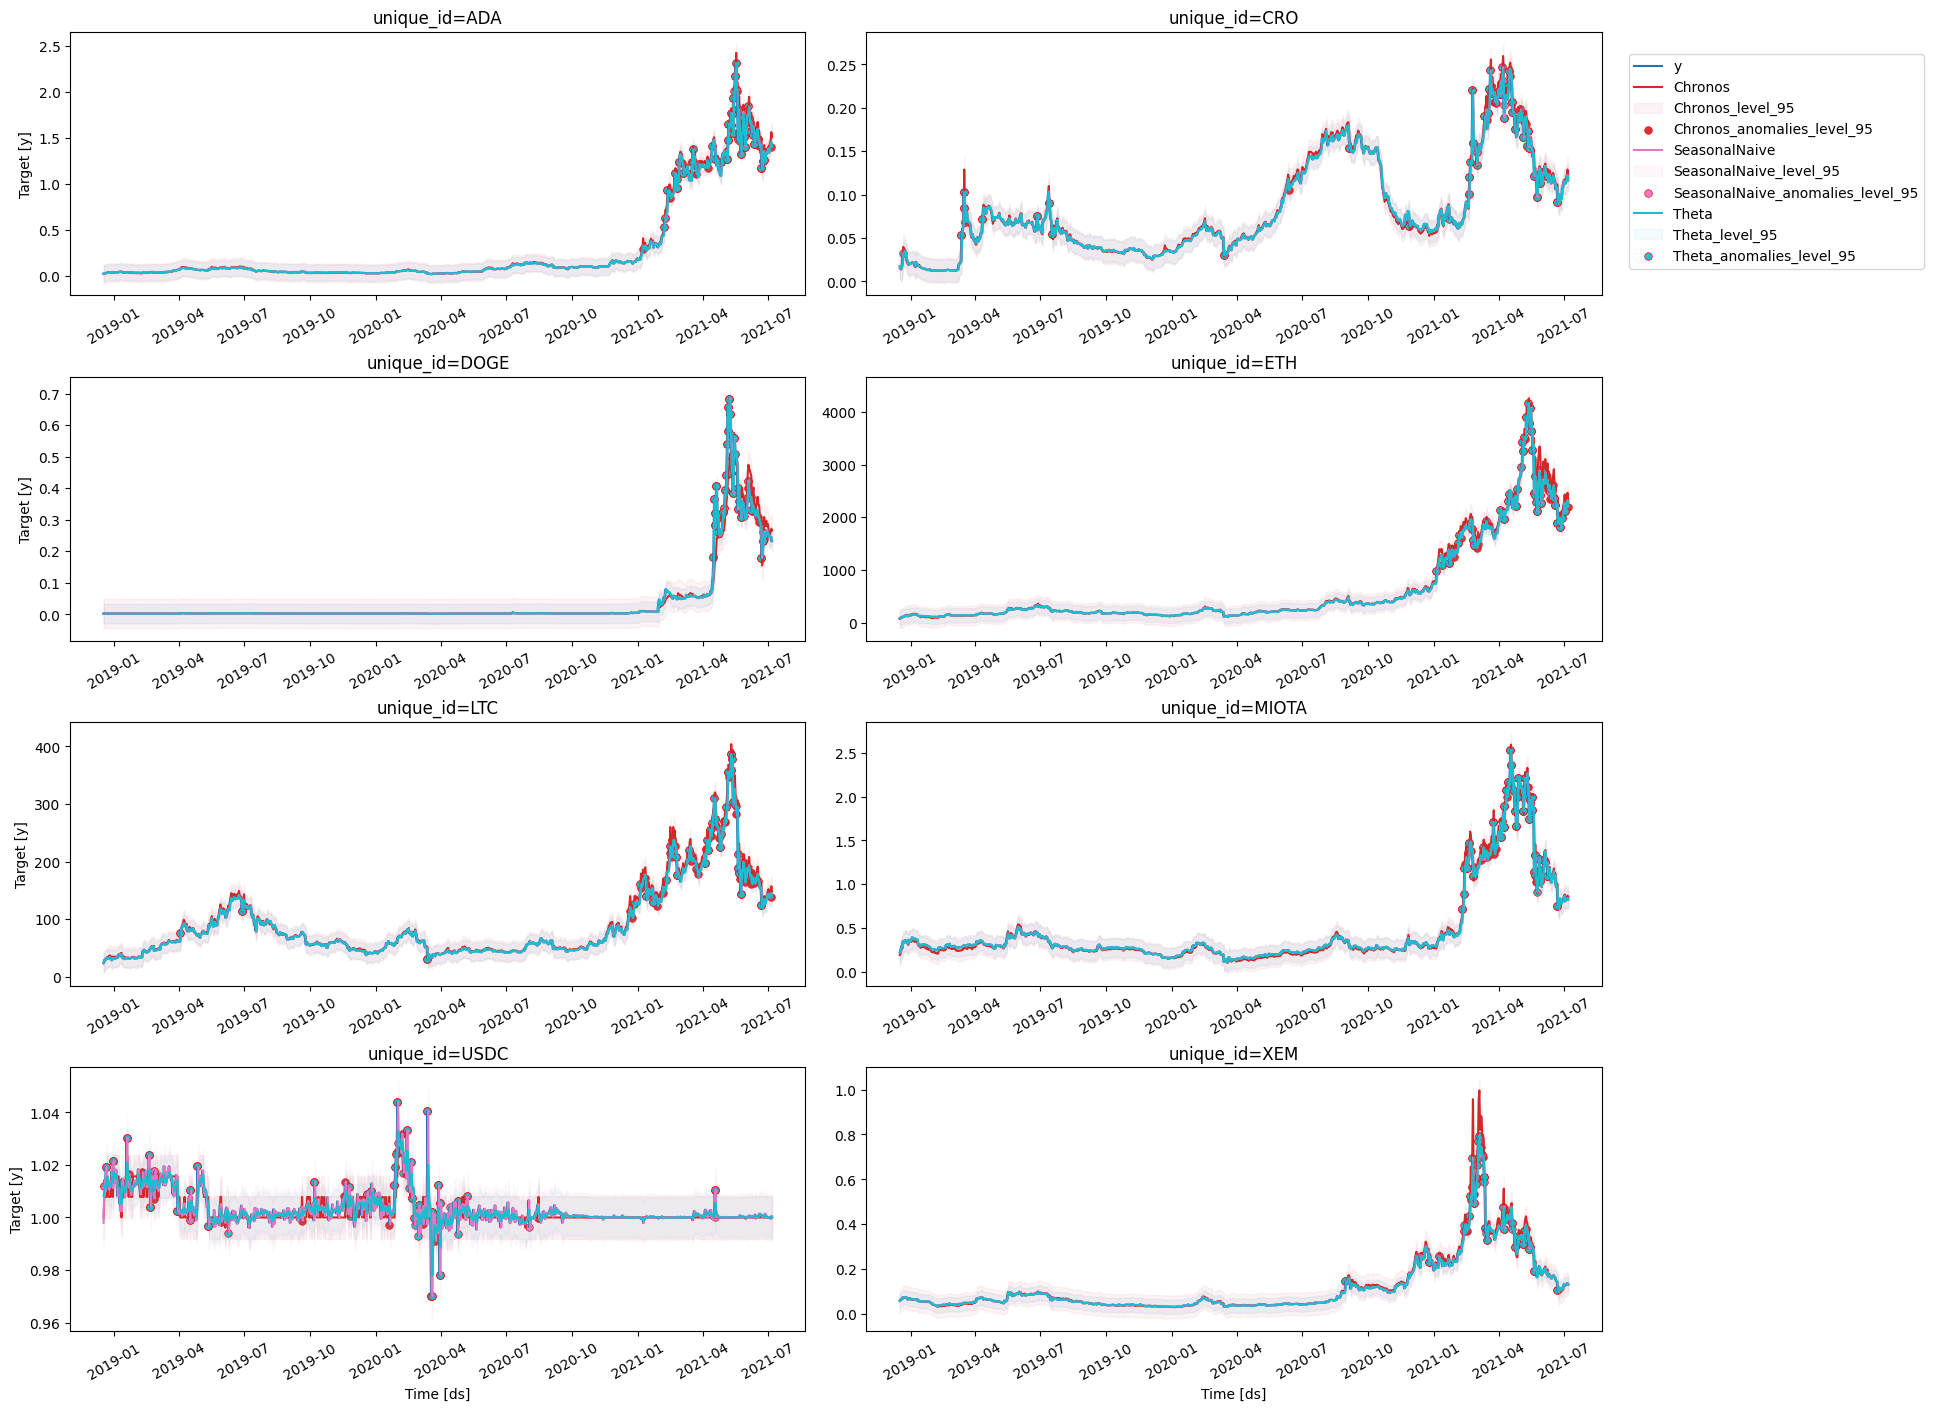

In [12]:
tcf.plot(big_df, anomalies_df)

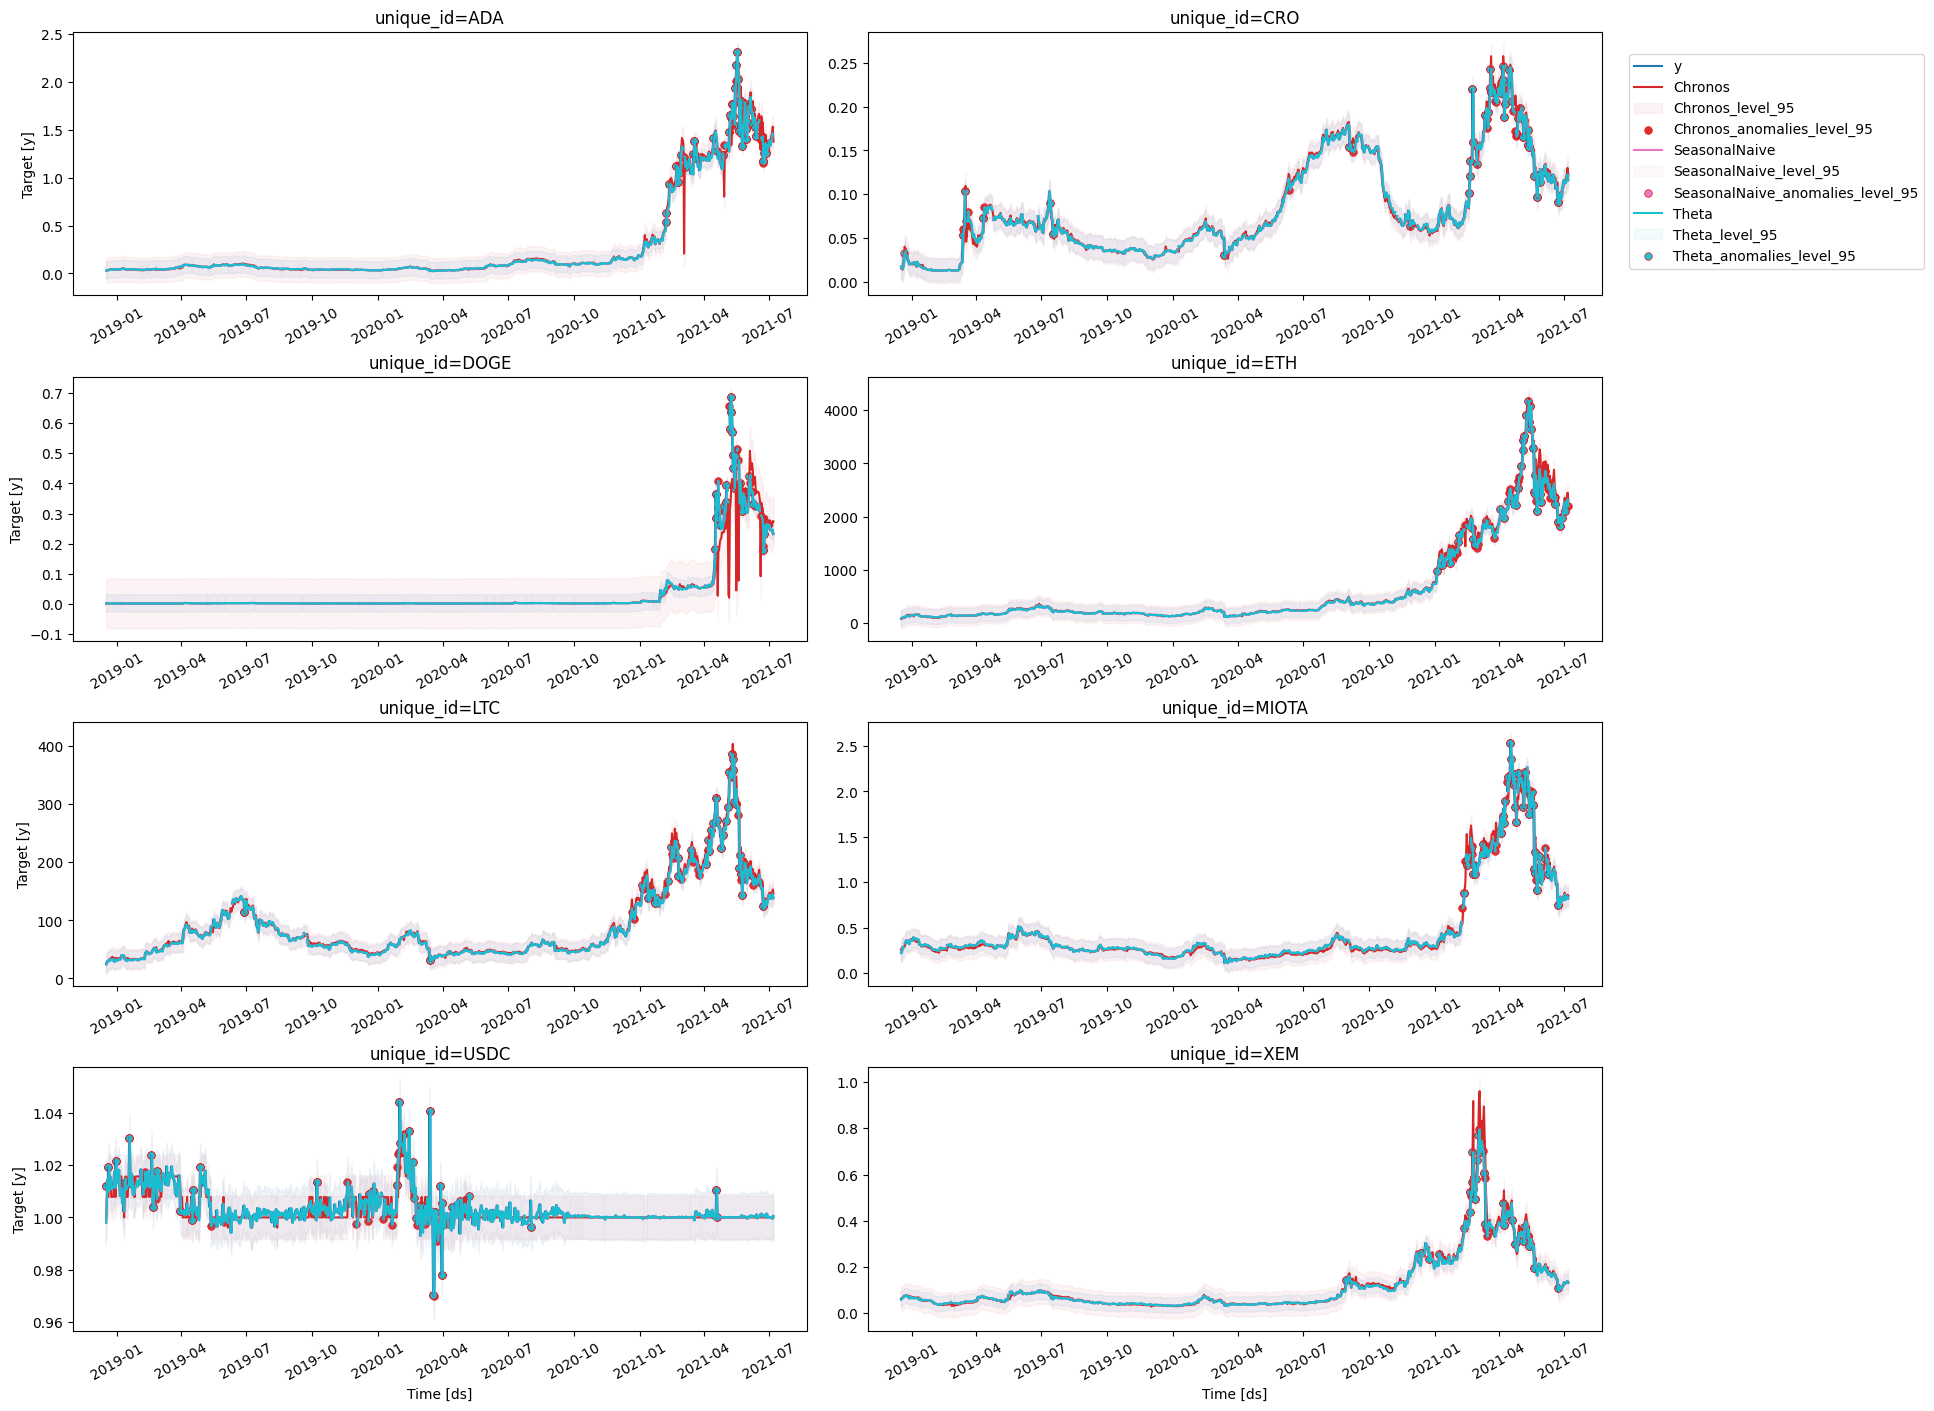

In [13]:
tcf.plot(df_missing, anomalies_df_missing)

The protocol for anomaly detection is visibly resilient to missing data. Other kinds of data corruption are encouraged for experimentation in further developments. So, in a context where missing data is a common issue, TimeCopilot will provide an equally robust environment for time series analysis. 

Notice the output is a dataframe that contains information regarding the anomaly detection in the form of a dataframe. 

In [53]:
anomaly_summary_xlm=anomalies_df[
    # (anomalies_df.unique_id=='SOL') & \
    ((anomalies_df['Chronos-anomaly']==True) | \
     (anomalies_df['SeasonalNaive-anomaly']==True) |
     (anomalies_df['Theta-anomaly']==True)
    )].reset_index(drop=True)
anomaly_summary_xlm

,unique_id,ds,cutoff,y,Chronos,...,SeasonalNaive-anomaly,Theta,Theta-lo-95,Theta-hi-95,Theta-anomaly
0,USDC,2018-12-16 23:59:59,2018-12-15 23:59:59,1.011961,1.000000,...,True,1.008144,1.000630,1.015657,False
1,USDC,2018-12-19 23:59:59,2018-12-18 23:59:59,1.019230,1.007812,...,True,1.011099,1.003585,1.018612,True
2,CRO,2018-12-20 23:59:59,2018-12-19 23:59:59,0.032447,0.021362,...,False,0.019062,0.006192,0.031932,True
3,USDC,2018-12-29 23:59:59,2018-12-28 23:59:59,1.021665,1.007812,...,True,1.013232,1.005719,1.020745,True
4,USDC,2019-01-10 23:59:59,2019-01-09 23:59:59,1.013104,1.000000,...,True,1.005168,0.997655,1.012682,True
...,...,...,...,...,...,...,...,...,...,...,...
473,ETH,2021-06-27 23:59:59,2021-06-26 23:59:59,1978.894662,1872.000000,...,True,1830.125990,1695.199458,1965.052523,True
474,ETH,2021-07-01 23:59:59,2021-06-30 23:59:59,2113.605523,2432.000000,...,True,2260.654426,2125.727894,2395.580959,True
475,ADA,2021-07-05 23:59:59,2021-07-04 23:59:59,1.404898,1.562500,...,False,1.453150,1.366867,1.539433,False
476,ETH,2021-07-05 23:59:59,2021-07-04 23:59:59,2198.582464,2464.000000,...,False,2309.879222,2174.952689,2444.805754,False


In [54]:
anomaly_summary_xlm=anomalies_df[
    (anomalies_df.unique_id=='ADA') & \
    ((anomalies_df['Chronos-anomaly']==True) | \
     (anomalies_df['SeasonalNaive-anomaly']==True) |
     (anomalies_df['Theta-anomaly']==True)
    )].reset_index(drop=True)
anomaly_summary_xlm

,unique_id,ds,cutoff,y,Chronos,...,SeasonalNaive-anomaly,Theta,Theta-lo-95,Theta-hi-95,Theta-anomaly
0,ADA,2021-01-07 23:59:59,2021-01-06 23:59:59,0.299980,0.412109,...,False,0.331084,0.244801,0.417367,False
1,ADA,2021-02-05 23:59:59,2021-02-04 23:59:59,0.537874,0.468750,...,True,0.440997,0.354714,0.527280,True
2,ADA,2021-02-06 23:59:59,2021-02-05 23:59:59,0.627886,0.617188,...,True,0.536850,0.450567,0.623133,True
3,ADA,2021-02-10 23:59:59,2021-02-09 23:59:59,0.930318,0.769531,...,True,0.703253,0.616970,0.789536,True
4,ADA,2021-02-14 23:59:59,2021-02-13 23:59:59,0.848419,0.968750,...,False,0.905874,0.819591,0.992157,False
...,...,...,...,...,...,...,...,...,...,...,...
55,ADA,2021-06-21 23:59:59,2021-06-20 23:59:59,1.177480,1.492188,...,True,1.425940,1.339657,1.512223,True
56,ADA,2021-06-23 23:59:59,2021-06-22 23:59:59,1.252896,1.132812,...,True,1.157866,1.071583,1.244149,True
57,ADA,2021-06-24 23:59:59,2021-06-23 23:59:59,1.356087,1.265625,...,True,1.244032,1.157749,1.330315,True
58,ADA,2021-06-25 23:59:59,2021-06-24 23:59:59,1.256478,1.421875,...,True,1.345591,1.259308,1.431874,True


In [55]:
anomaly_summary_xlm=anomalies_df[
    (anomalies_df.unique_id=='ADA') & \
    ((anomalies_df['Chronos-anomaly']==True) & \
     (anomalies_df['SeasonalNaive-anomaly']==True) \
    #  (anomalies_df['Theta-anomaly']==True)
    )].reset_index(drop=True)
anomaly_summary_xlm

,unique_id,ds,cutoff,y,Chronos,...,SeasonalNaive-anomaly,Theta,Theta-lo-95,Theta-hi-95,Theta-anomaly
0,ADA,2021-02-10 23:59:59,2021-02-09 23:59:59,0.930318,0.769531,...,True,0.703253,0.616970,0.789536,True
1,ADA,2021-02-20 23:59:59,2021-02-19 23:59:59,1.122958,0.960938,...,True,0.927477,0.841194,1.013760,True
2,ADA,2021-02-23 23:59:59,2021-02-22 23:59:59,0.954709,1.140625,...,True,1.099138,1.012855,1.185421,True
3,ADA,2021-02-26 23:59:59,2021-02-25 23:59:59,1.241105,1.117188,...,True,1.078809,0.992526,1.165092,True
4,ADA,2021-03-04 23:59:59,2021-03-03 23:59:59,1.114868,1.242188,...,True,1.216680,1.130397,1.302963,True
...,...,...,...,...,...,...,...,...,...,...,...
31,ADA,2021-06-11 23:59:59,2021-06-10 23:59:59,1.436378,1.593750,...,True,1.540859,1.454576,1.627142,True
32,ADA,2021-06-16 23:59:59,2021-06-15 23:59:59,1.482573,1.671875,...,True,1.595523,1.509240,1.681806,True
33,ADA,2021-06-21 23:59:59,2021-06-20 23:59:59,1.177480,1.492188,...,True,1.425940,1.339657,1.512223,True
34,ADA,2021-06-23 23:59:59,2021-06-22 23:59:59,1.252896,1.132812,...,True,1.157866,1.071583,1.244149,True


e.g. for the price of ADA, we can look at 60 anomaly points on any of the algorithms used for its detection, but only 35 that are anomalies within the context of Chronos and Seasonal naive regressors. 

#### Forecasting use 
Now, we're going to execute the whole forecasting process for both dataframes and take a look at the results. Let's create a secondary forecaster in order to have more models to evaluate and create a final forecast. 

Remember, you can optionally specify the following parameters:
- freq: The frequency of your data (e.g., 'D' for daily, 'M' for monthly)
- h: The forecast horizon, which is the number of periods to predict
- seasonality: The seasonal period of your data, which can be inferred if not provided

Remember we won't give data frequency, since crypto sampling is sort of arbitrary. Seasonality is best to leave blank, since price spikes and movements might or might not follow a specific trend. In this case, we're asking for the next 21 days closing price for each index. 

In [15]:
tcf1 = TimeCopilotForecaster(
    models=[
        AutoARIMA(), 
        Chronos(repo_id="amazon/chronos-bolt-mini"),
        Theta(),
        AutoETS(), 
        Moirai(), 
        Prophet(), 
        SeasonalNaive(),
    ]
)

In [ ]:
fcst_df = tcf1.forecast(df=big_df, h=30, level=[80,90])

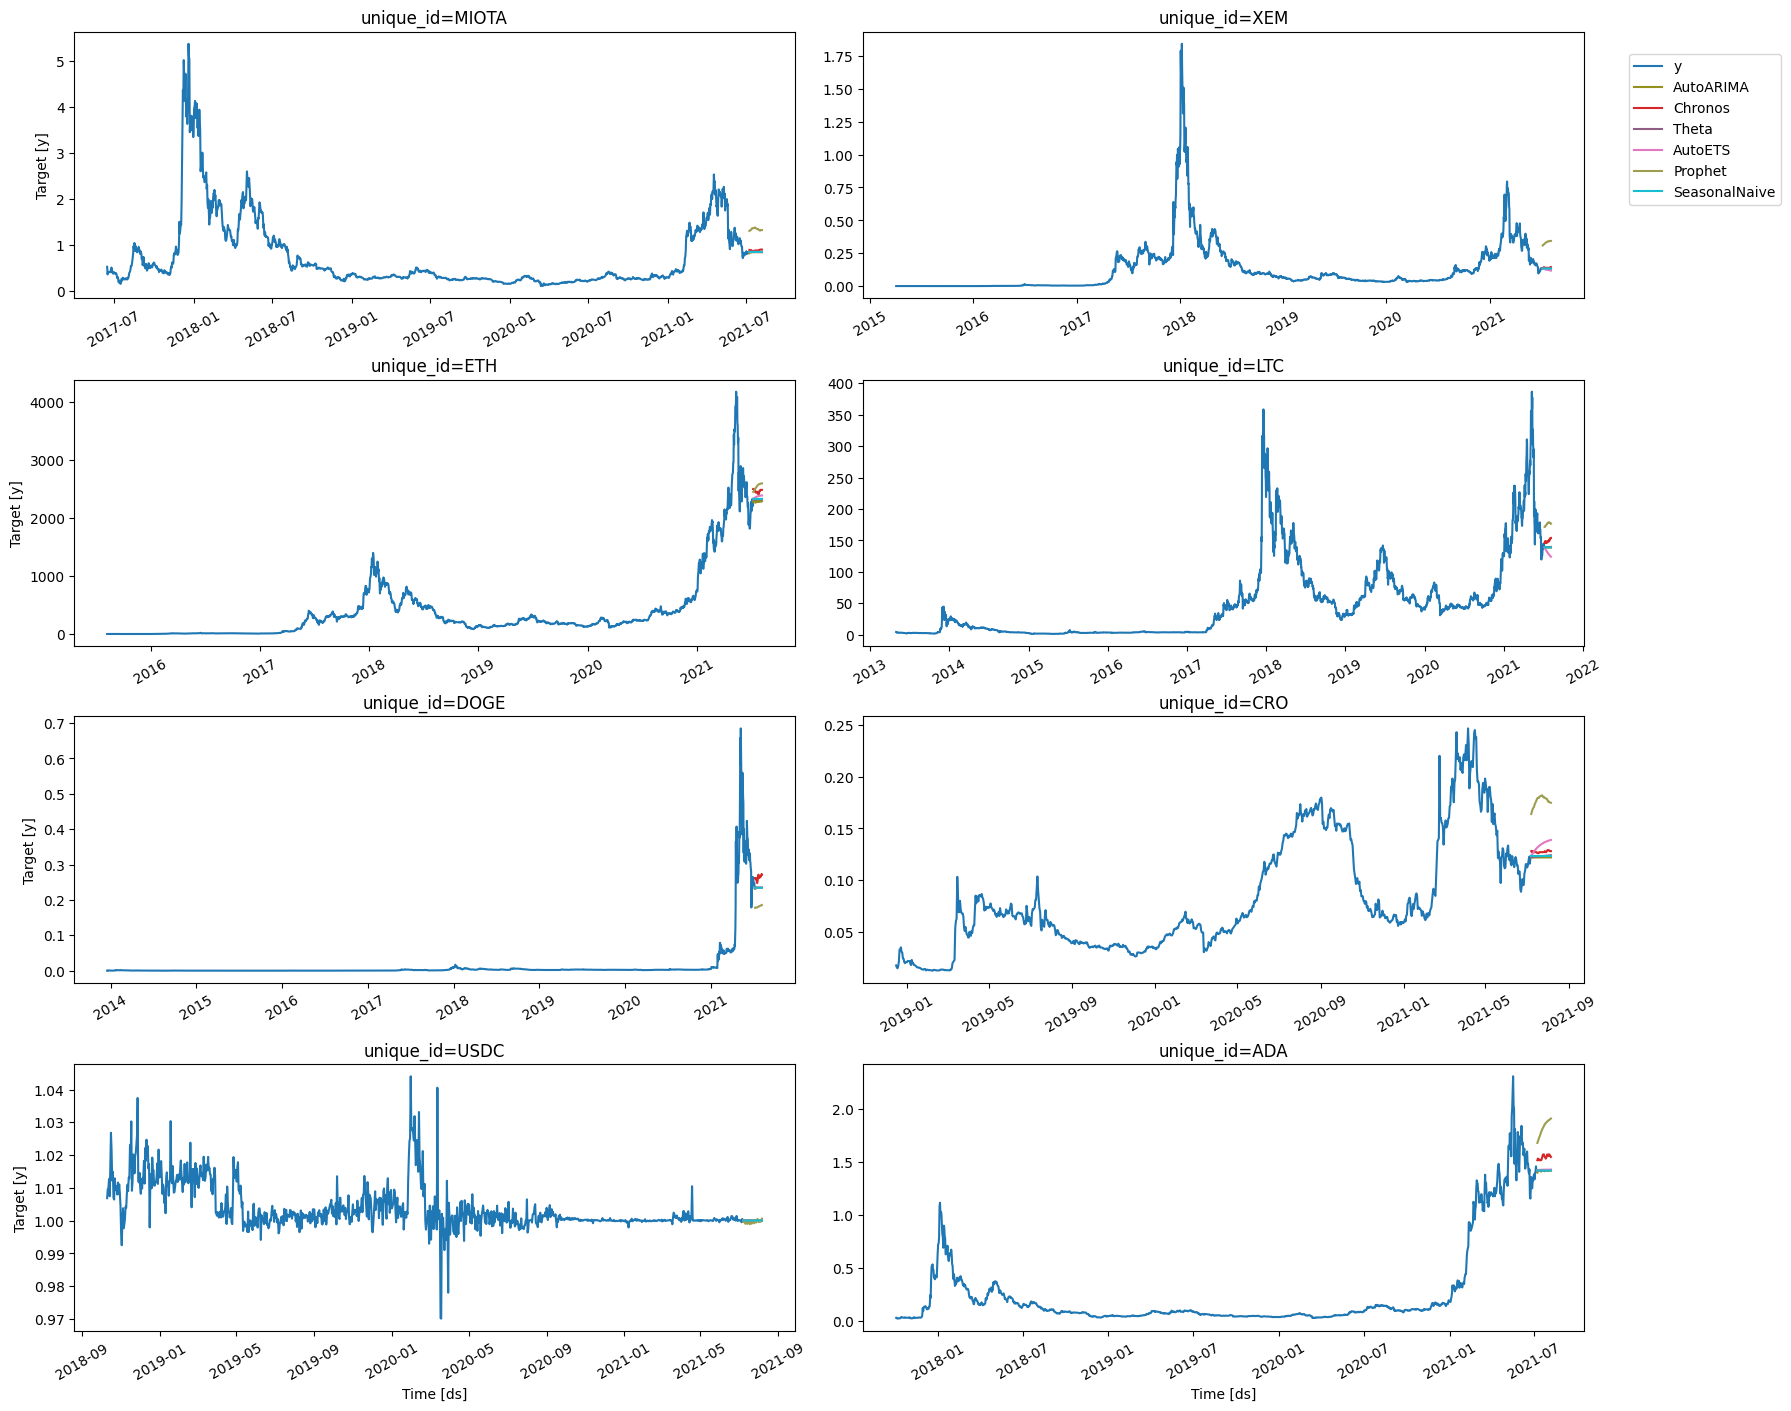

In [56]:
tcf1.plot(big_df, fcst_df)

This way we can take a look at an algorithm result we're most interested in. Since the output is a pandas dataframe, it's easy to extract.

We can try Ethereum, ETH symbol. 

For example, let's extract the Chronos lower estimate to establish a baseline. Let's also compare it to the Chronos output for the same symbol

In [57]:
eth_fcst_normal=fcst_df[(fcst_df.unique_id=='ETH')]\
    [['unique_id','ds','Chronos','Chronos-lo-80']]\
    .reset_index(drop=True)

Let's plot the results for the tampered data forecasts

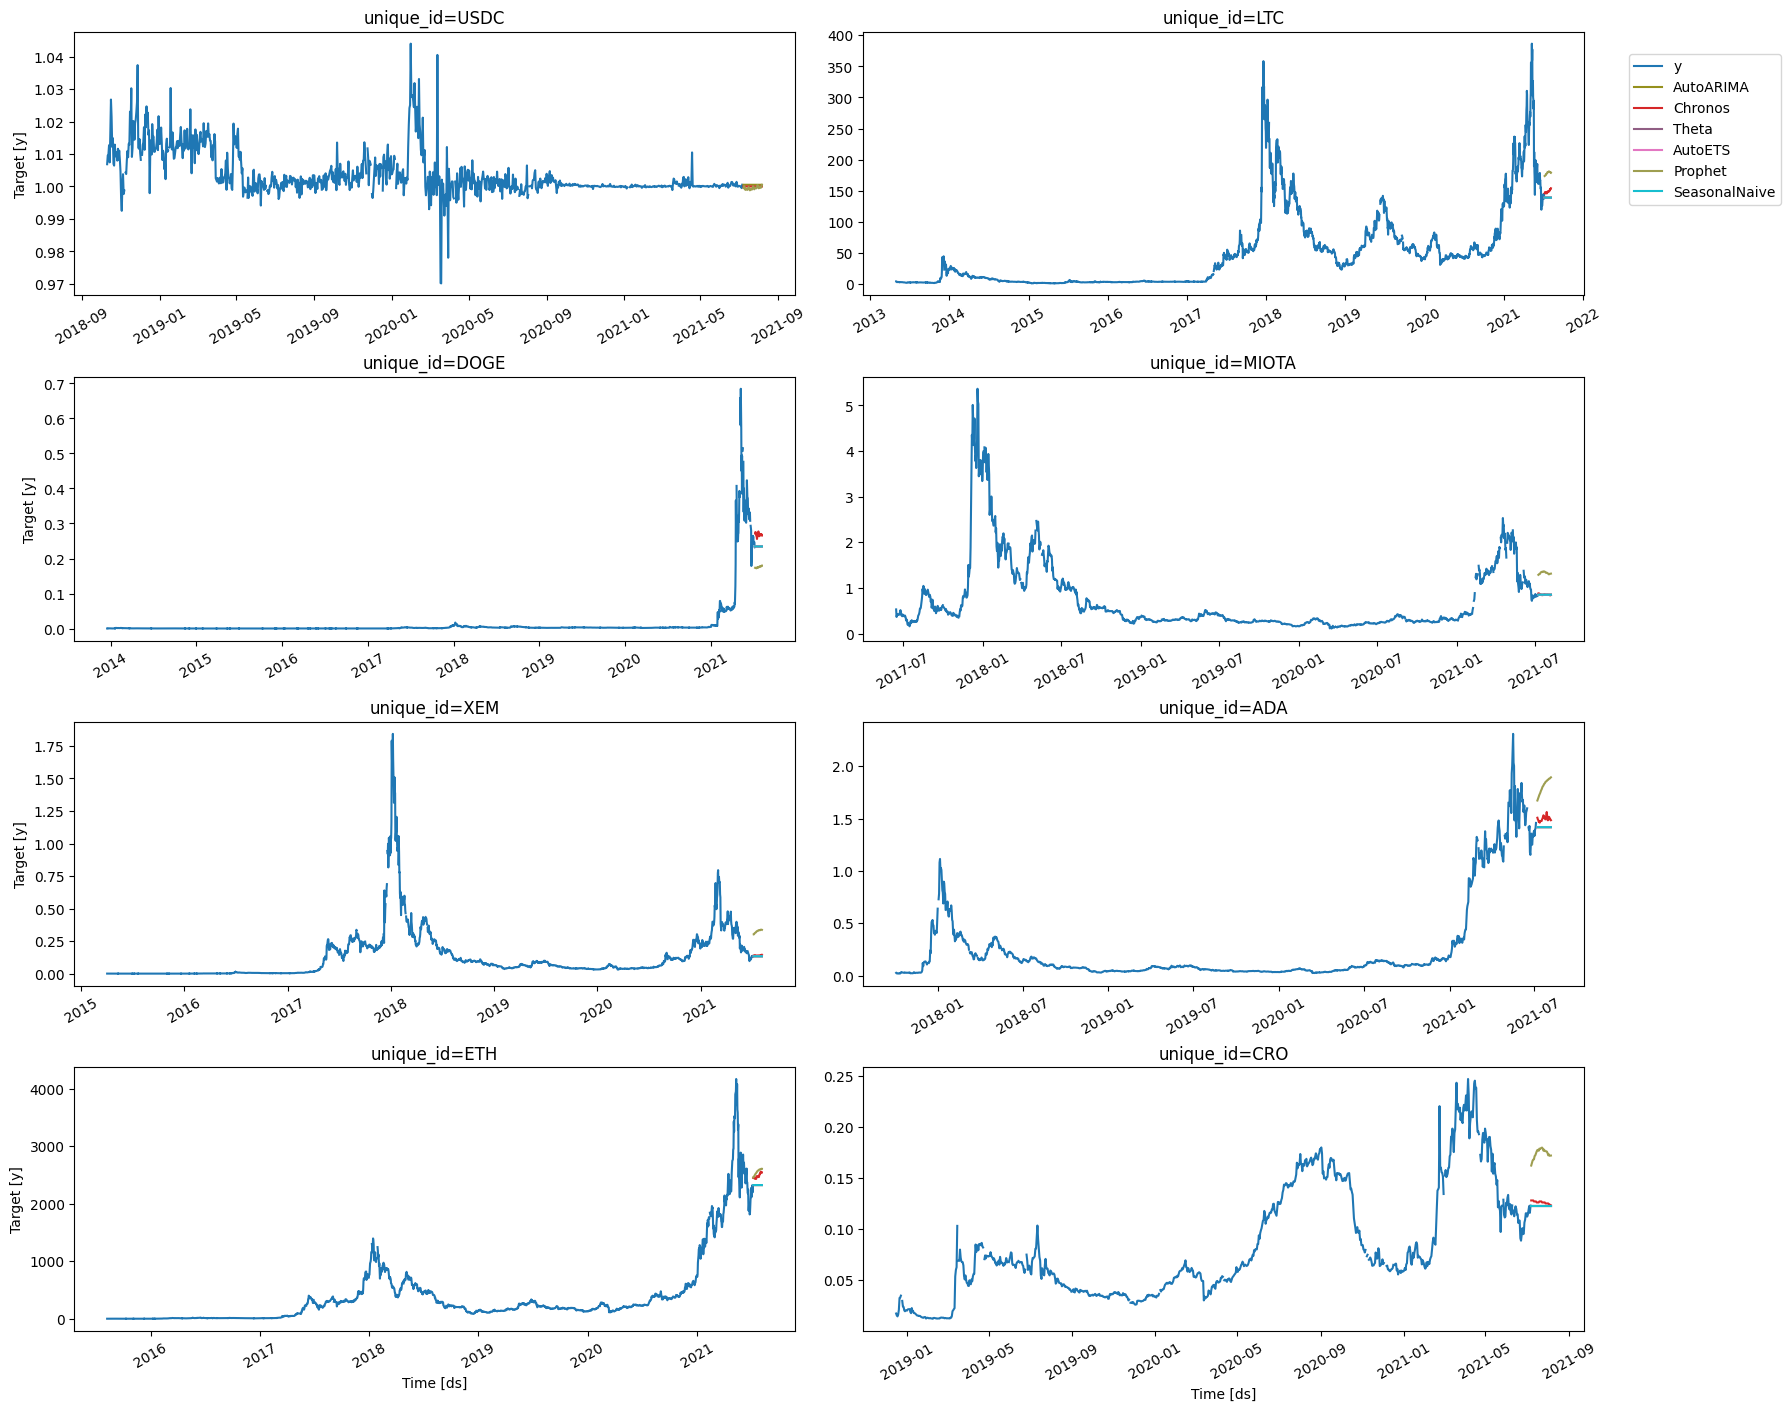

In [58]:
tcf1.plot(df_missing, fcst_df_missing)

In [59]:
eth_fcst_missing=fcst_df[(fcst_df.unique_id=='ETH')]\
    [['unique_id','ds','Chronos','Chronos-lo-80']]\
    .reset_index(drop=True)

In [60]:
eth_fcst_missing

,unique_id,ds,Chronos,Chronos-lo-80
0,ETH,2021-07-07 23:59:59,2496.0,2208.0
1,ETH,2021-07-08 23:59:59,2496.0,2144.0
2,ETH,2021-07-09 23:59:59,2480.0,2096.0
3,ETH,2021-07-10 23:59:59,2496.0,2080.0
4,ETH,2021-07-11 23:59:59,2496.0,2048.0
...,...,...,...,...
25,ETH,2021-08-01 23:59:59,2480.0,1712.0
26,ETH,2021-08-02 23:59:59,2480.0,1712.0
27,ETH,2021-08-03 23:59:59,2480.0,1688.0
28,ETH,2021-08-04 23:59:59,2480.0,1680.0


Finally, let's take a glimpse to see how much these two datasets differ in order to learn about the resiliency of TimeCopilot's frameworks con tampered data

In [64]:
compare=eth_fcst_normal.merge(eth_fcst_missing,on=['ds','unique_id'])
compare['dif']=abs(compare['Chronos_x']-compare['Chronos_y'])
print(compare['dif'].sum())

0.0


While the closeness of the algorithm results will depend entirely on the data, and its tampering, it's important to remark that the adjustment is feasible and that TimeCopilot is able to handle corrupted time series data on real datasets. 